In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import warnings
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")


In [3]:
from utils import (
    extract_page_components, 
    extract_main_domain, 
    get_date_columns, 
    remove_incomplete_rows, 
    plot_time_series, 
    plot_seasonal_decompose,
    check_stationarity
)

In [4]:
data = pd.read_csv('../data/train_2.csv')
data.rename(columns={
    'Page': 'page'
}, inplace=True)
data.shape

(145063, 804)

In [5]:
date_columns = get_date_columns(data)

In [6]:
t_data = data.dropna().iloc[10:20, :].copy()
t_data

,page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
14,Android_zh.wikipedia.org_all-access_spider,8.0,27.0,9.0,25.0,25.0,10.0,34.0,22.0,17.0,...,36.0,32.0,51.0,40.0,49.0,48.0,38.0,85.0,41.0,38.0
15,Angelababy_zh.wikipedia.org_all-access_spider,40.0,17.0,25.0,42.0,41.0,7.0,18.0,21.0,33.0,...,24.0,22.0,19.0,18.0,30.0,66.0,24.0,37.0,21.0,23.0
16,Apink_zh.wikipedia.org_all-access_spider,61.0,33.0,21.0,10.0,26.0,11.0,39.0,195.0,62.0,...,38.0,27.0,42.0,22.0,21.0,30.0,77.0,32.0,105.0,18.0
17,Apple_II_zh.wikipedia.org_all-access_spider,4.0,8.0,4.0,9.0,7.0,4.0,15.0,9.0,17.0,...,8.0,5.0,11.0,17.0,9.0,16.0,8.0,14.0,9.0,14.0
18,As_One_zh.wikipedia.org_all-access_spider,13.0,7.0,14.0,11.0,20.0,5.0,32.0,11.0,6.0,...,16.0,11.0,19.0,8.0,16.0,8.0,22.0,12.0,9.0,4.0
20,B1A4_zh.wikipedia.org_all-access_spider,22.0,11.0,23.0,10.0,6.0,12.0,74.0,17.0,38.0,...,13.0,22.0,20.0,17.0,12.0,30.0,46.0,19.0,34.0,20.0
21,BDSM_zh.wikipedia.org_all-access_spider,25.0,3.0,3.0,4.0,12.0,14.0,16.0,15.0,22.0,...,53.0,22.0,24.0,22.0,13.0,17.0,22.0,26.0,17.0,14.0
22,BEAST_zh.wikipedia.org_all-access_spider,19.0,6.0,12.0,14.0,13.0,7.0,12.0,64.0,9.0,...,9.0,10.0,13.0,15.0,7.0,15.0,12.0,18.0,9.0,15.0
23,BIGBANG_zh.wikipedia.org_all-access_spider,23.0,24.0,31.0,9.0,21.0,27.0,15.0,8.0,50.0,...,84.0,40.0,43.0,51.0,43.0,40.0,60.0,39.0,37.0,27.0
25,BLEACH_zh.wikipedia.org_all-access_spider,11.0,5.0,13.0,8.0,6.0,5.0,8.0,5.0,12.0,...,11.0,14.0,14.0,32.0,13.0,21.0,14.0,19.0,13.0,19.0


In [7]:
t_data.set_index('page', inplace=True)
t_data = t_data.T
t_data.index = pd.to_datetime(t_data.index)
t_data.head()

page,Android_zh.wikipedia.org_all-access_spider,Angelababy_zh.wikipedia.org_all-access_spider,Apink_zh.wikipedia.org_all-access_spider,Apple_II_zh.wikipedia.org_all-access_spider,As_One_zh.wikipedia.org_all-access_spider,B1A4_zh.wikipedia.org_all-access_spider,BDSM_zh.wikipedia.org_all-access_spider,BEAST_zh.wikipedia.org_all-access_spider,BIGBANG_zh.wikipedia.org_all-access_spider,BLEACH_zh.wikipedia.org_all-access_spider
2015-07-01,8.0,40.0,61.0,4.0,13.0,22.0,25.0,19.0,23.0,11.0
2015-07-02,27.0,17.0,33.0,8.0,7.0,11.0,3.0,6.0,24.0,5.0
2015-07-03,9.0,25.0,21.0,4.0,14.0,23.0,3.0,12.0,31.0,13.0
2015-07-04,25.0,42.0,10.0,9.0,11.0,10.0,4.0,14.0,9.0,8.0
2015-07-05,25.0,41.0,26.0,7.0,20.0,6.0,12.0,13.0,21.0,6.0


### Baseline ARIMA

In [8]:
def fit_sarima(series, p, d, q, P, D, Q, s, exog=None):
    model = SARIMAX(series, exog=exog, order=(p, d, q), seasonal_order=(P, D, Q, s))
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            fitted_model = model.fit(disp=False)
    except Exception as e:
        print(f"Fitting SARIMA({p},{d},{q}) x ({P},{D},{Q},{s}) failed with default start parameters: {e}")
        # Retry with initial parameters set to zero
        try:
            fitted_model = model.fit(start_params=[0] * (p + q + P + Q))
        except Exception as e:
            print(f"Retry fitting SARIMA({p},{d},{q}) x ({P},{D},{Q},{s}) failed: {e}")
            return None
    return fitted_model

def find_best_sarima_model(time_series, p_values, d_values, q_values, P_values, D_values, Q_values, s, exog=None):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                model = fit_sarima(time_series, p, d, q, P, D, Q, s, exog)
                                if model is not None and model.aic < best_aic:
                                    best_aic = model.aic
                                    best_order = (p, d, q)
                                    best_seasonal_order = (P, D, Q, s)
                                    best_model = model
                            except Exception as e:
                                print(f"Failed to fit SARIMA({p},{d},{q}) x ({P},{D},{Q},{s}): {str(e)}")
    
    return {"order": best_order, "seasonal_order": best_seasonal_order, "model": best_model, "aic": best_aic}


In [9]:
def get_time_series_and_exog(data, page_name):
    time_series = data[page_name]
    time_series = time_series.asfreq('D')
    
     # Day of the week
    day_of_week = pd.to_datetime(time_series.index).dayofweek
    exog_dow = pd.get_dummies(day_of_week, prefix='dow').astype(int)
    exog_dow.index = time_series.index
    
    # Month of the year
    month_of_year = pd.to_datetime(time_series.index).month
    exog_month = pd.get_dummies(month_of_year, prefix='month').astype(int)
    exog_month.index = time_series.index
    
    # Is weekend
    is_weekend = (day_of_week >= 5).astype(int)
    exog_weekend = pd.DataFrame(is_weekend, index=time_series.index, columns=['is_weekend'])
    
    # Is holiday
    holidays = calendar().holidays(start=time_series.index.min(), end=time_series.index.max())
    is_holiday = time_series.index.isin(holidays).astype(int)
    exog_holiday = pd.DataFrame(is_holiday, index=time_series.index, columns=['is_holiday'])
    
    # Combine all exogenous features
    exog = pd.concat([exog_dow, exog_month, exog_weekend, exog_holiday], axis=1)
    
    return time_series, exog

In [10]:
def train_test_split(series, exog, test_size):
    train = series[:-test_size]
    test = series[-test_size:]
    train_exog = exog[:-test_size]
    test_exog = exog[-test_size:]
    return train, test, train_exog, test_exog

In [11]:
def process_page(page_name, data, date_columns, p_values, d_values, q_values, P_values, D_values, Q_values, S, test_size):
    print(f"Processing SARIMA models for page: {page_name}")
        
    # Get the time series data for the page
    time_series, exog = get_time_series_and_exog(data, page_name)
    
    # Skip the current iteration if no data was found
    if time_series is None:
        return

    # Determine if the series is stationary
    is_stationary = check_stationarity(time_series)

    # Adjust d_values based on stationarity
    adjusted_d_values = [0] if is_stationary else d_values

    # Split the data into training and testing sets
    train_series, test_series, train_exog, test_exog =  train_test_split(time_series, exog, test_size)

    # Find the best ARIMA model for the time series
    best_model_info = find_best_sarima_model(train_series, p_values, adjusted_d_values, q_values, P_values, D_values, Q_values, S, exog=train_exog)
    
    print(f"Best SARIMA model for {page_name}: Order={best_model_info['order']} AIC={best_model_info['aic']:.2f}")

    return best_model_info


def process_all_pages(data, date_columns, p_values, d_values, q_values, P_values, D_values, Q_values, S, test_size):
    results = {}
    
    # Iterate over all unique pages in the DataFrame
    for page_name in data.columns:
        best_model_info = process_page(page_name, data, date_columns, p_values, d_values, q_values, P_values, D_values, Q_values, S, test_size)
        if best_model_info is not None:
            results[page_name] = best_model_info

    return results

In [52]:
p_values = [0]
d_values = [4]
q_values = [0]
P_values = [1]
D_values = [1]
Q_values = [0]
s = 60

test_size = 30
best_models_per_page = process_all_pages(t_data[['Angelababy_zh.wikipedia.org_all-access_spider']], date_columns, p_values, d_values, q_values, P_values, D_values, Q_values, s, test_size)

Processing SARIMA models for page: Angelababy_zh.wikipedia.org_all-access_spider
Best SARIMA model for Angelababy_zh.wikipedia.org_all-access_spider: Order=(0, 0, 0) AIC=7434.53


In [43]:
def smape(actual, forecast):
    return 100 * np.mean(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

In [50]:
def check_residuals(model):
    residuals = model.resid
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    residuals.plot(ax=ax[0], title="Residuals")
    residuals.plot(kind='kde', ax=ax[1], title="Density")
    plt.show()
    
def plot_forecast_vs_actual(train_series, test_series, train_exog, test_exog, model):
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(train_series, label='Train', color='blue', linewidth=1)
    ax.plot(test_series, label='Test', color='orange', linewidth=1)
    
    # In-sample forecast
    in_sample_forecast = model.fittedvalues
    ax.plot(in_sample_forecast, label='In-sample Forecast', color='green', linestyle='--', linewidth=2)
    
    # Out-of-sample forecast
    forecast = model.get_forecast(steps=len(test_series), exog=test_exog)
    forecast_index = pd.date_range(start=test_series.index[0], periods=len(test_series), freq='D')
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
    ax.plot(forecast_series, label='Out-of-sample Forecast', color='red', linestyle='--', linewidth=2)

    sMAPE_value = smape(test_series, forecast_series)
    print(f'sMAPE: {sMAPE_value:.2f}%')
    
    # Adding titles and labels
    ax.set_title('Actual vs Forecasted Values', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Page Views', fontsize=14)
    
    # Adding legend
    ax.legend(loc='upper left', fontsize=12)
    
    # Adding grid for better readability
    ax.grid(True)
    
    # Improving the appearance
    plt.tight_layout()
    
    plt.show()

def plot_model_forecast(data, best_models_per_page, date_columns, page_name, test_size):
    if page_name not in best_models_per_page:
        print(f"No model found for page: {page_name}")
        return
    
    best_model_info = best_models_per_page[page_name]
    model = best_model_info['model']
    
    time_series, exog = get_time_series_and_exog(data, page_name)
    
    if time_series is not None:
        train_series, test_series, train_exog, test_exog = train_test_split(time_series, exog, test_size)
        plot_forecast_vs_actual(train_series, test_series, train_exog, test_exog, model)
        check_residuals(model)

sMAPE: 45.18%


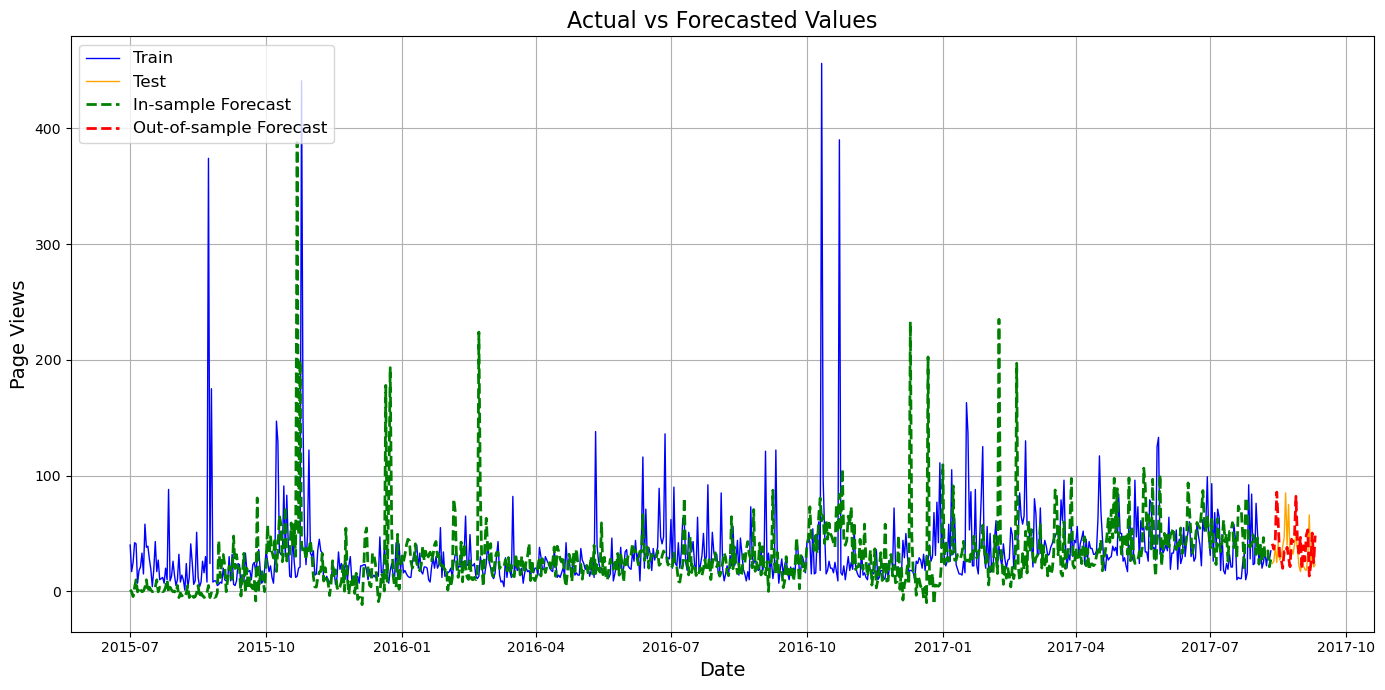

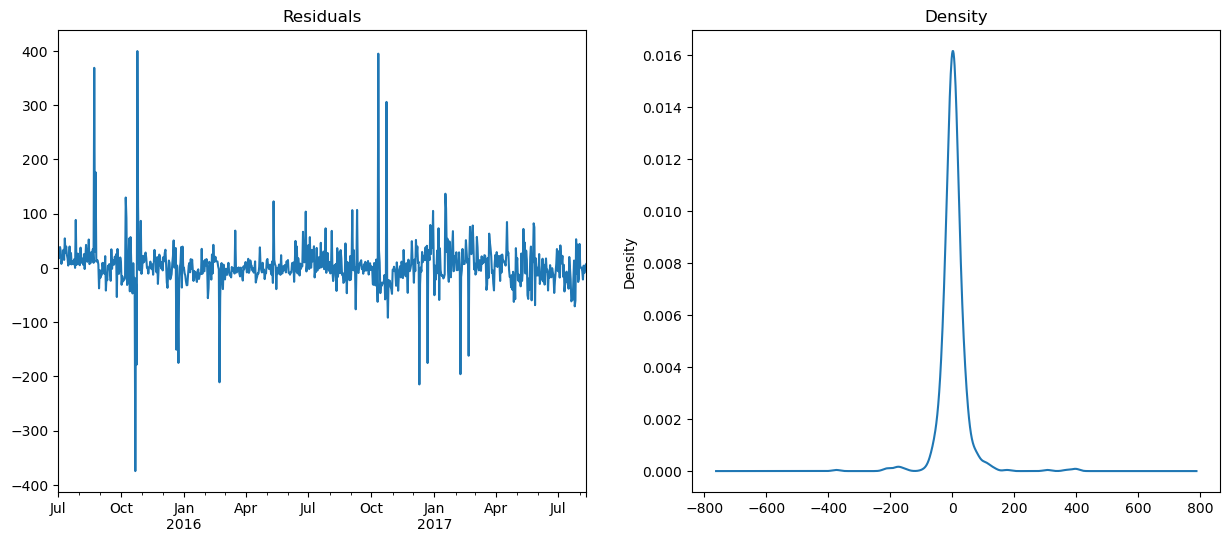

In [51]:
page_name = 'Angelababy_zh.wikipedia.org_all-access_spider'

plot_model_forecast(t_data, best_models_per_page, date_columns, page_name, test_size)